In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

import pickle

In [3]:
def cv_sklearn (model_name, fun_create_model, df, cols, score_column, early_stopping_rounds = None):

    pred = np.zeros ((df.shape[0]))

    for fold in range(5):
        train = df.query ("kfold != @fold")
        valid = df.query ("kfold == @fold")

        X_train = train [cols].values
        y_train = train[score_column].values

        X_valid = valid [cols].values
        y_valid = valid[score_column].values

        model = fun_create_model ()
        if not early_stopping_rounds is None:
            model.fit(X_train, y_train, 
                      early_stopping_rounds = early_stopping_rounds, 
                      eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=0)
        else:
            model.fit(X_train, y_train)    
        pred_train = model.predict ( X_train )
        pred_valid = model.predict ( X_valid )

        pred [valid.index.values] = pred_valid

        rmse_train = mean_squared_error ( y_train, pred_train, squared = False )

        rmse_valid = mean_squared_error ( y_valid, pred_valid, squared = False )
        print (f"fold:{fold} rmse_train:{rmse_train:.5f}, rmse_valid:{rmse_valid:.5f}")
        pickle.dump(model, open(f"../models/{model_name}_{fold}.pkl", 'wb'))


    y_true = df[score_column]
    rmse_tot = mean_squared_error ( y_true, pred, squared = False )
    print (f"tot rmse_tot:{rmse_tot:.5f}")
    return pred

def show_rmse (y_true, pred, model_name):
    rmse_tot = mean_squared_error ( y_true, pred, squared = False )

    plt.figure (figsize = (6,6))
    plt.scatter (y_true,  pred)

    plt.title(f"{model_name}: rmse_tot:{rmse_tot:.5f}")
    plt.show()

def create_validation_features ():
    df_valid_pair = pd.read_csv("../processed/validation.csv")
    df_valid_fe = pd.read_csv("../processed/valid_text_detoxify_fe.csv")

    df_valid_fe_2 = pd.read_csv("../processed/valid_text_jc_tfidf_fe.csv")
    df_valid_fe_2 = df_valid_fe_2[["jc_tfidf_toxic","jc_tfidf_severe_toxic","jc_tfidf_obscene","jc_tfidf_threat","jc_tfidf_insult","jc_tfidf_identity_hate"]]
    
    df_valid_fe_3 = pd.read_csv("../processed/valid_text_juc_tfidf_fe.csv")
    df_valid_fe_3 = df_valid_fe_3[['juc_tfidf_toxicity', 'juc_tfidf_severe_toxicity','juc_tfidf_obscene', 'juc_tfidf_sexual_explicit','juc_tfidf_identity_attack', 'juc_tfidf_insult', 'juc_tfidf_threat']]
    
    df_valid_fe = pd.concat ( [df_valid_fe,df_valid_fe_2, df_valid_fe_3], axis=1)    
    
    return df_valid_pair, df_valid_fe

    
def create_rud_features ():
    df_valid_pair = pd.read_csv("../processed/rud_pair.csv")
    df_valid_fe = pd.read_csv("../processed/rud_text_detoxify_fe.csv")

    df_valid_fe_2 = pd.read_csv("../processed/rud_text_jc_tfidf_fe.csv")
    df_valid_fe_2 = df_valid_fe_2[["jc_tfidf_toxic","jc_tfidf_severe_toxic","jc_tfidf_obscene","jc_tfidf_threat","jc_tfidf_insult","jc_tfidf_identity_hate"]]

    df_valid_fe_3 = pd.read_csv("../processed/rud_text_juc_tfidf_fe.csv")
    df_valid_fe_3 = df_valid_fe_3[['juc_tfidf_toxicity', 'juc_tfidf_severe_toxicity','juc_tfidf_obscene', 'juc_tfidf_sexual_explicit','juc_tfidf_identity_attack', 'juc_tfidf_insult', 'juc_tfidf_threat']]
    
    df_valid_fe = pd.concat ( [df_valid_fe,df_valid_fe_2, df_valid_fe_3], axis=1)    
    
    return df_valid_pair, df_valid_fe


def validate(df_valid_pair,df_valid_text, pred):
    

    ### rud
    if "comment_id" in df_valid_text.columns:
        m = { a:b for a, b in zip(df_valid_text["comment_id"].values, pred)  }
        p_less = df_valid_pair["less_toxic_id"].map(lambda x: m[x] )
        p_more = df_valid_pair["more_toxic_id"].map(lambda x: m[x] )
        return (p_less < p_more).mean()
    
    else:
        m = { a:b for a, b in zip(df_valid_text["text"].values, pred)  }
        
        df_valid_pair = df_valid_pair.copy()
        #df_valid_pair = df_valid_pair.query("count == 3").copy()
        
        df_valid_pair["less_toxic_score"] = df_valid_pair["less_toxic"].map(lambda x: m[x] )
        df_valid_pair["more_toxic_score"] = df_valid_pair["more_toxic"].map(lambda x: m[x] )
        
        d_a = df_valid_pair.query("less_toxic_score < more_toxic_score and avg_agreement == 1.0") 
        d_b = df_valid_pair.query("less_toxic_score < more_toxic_score and avg_agreement < 1.0") 
        d_c = df_valid_pair.query("less_toxic_score > more_toxic_score and avg_agreement < 1.0") 

        return (d_a["count"].sum() + d_b.shape[0]*2 + d_c.shape[0])/df_valid_pair["count"].sum()
    

def avg_predict (df_valid_text, cols):
    for k, col in enumerate(cols):
        p = rankdata(df_valid_text[col].values, method='ordinal')

        if k == 0:
            y = p
        else:    
            y = y + p  
    return y

def sklearn_predict (df_valid_text, model_path, model_name, cols, folds = 5):
    pred = np.zeros ((df_valid_text.shape[0]))
    X = df_valid_text [cols].values


    for fold in range(5):
        model = pickle.load(open(f"{model_path}/{model_name}_{fold}.pkl", 'rb'))

        pred += model.predict ( X )
        
    return pred    

MODEL ridge_rud
fold:0 rmse_train:0.20904, rmse_valid:0.21182
fold:1 rmse_train:0.20964, rmse_valid:0.20923
fold:2 rmse_train:0.20926, rmse_valid:0.21044
fold:3 rmse_train:0.21020, rmse_valid:0.20662
fold:4 rmse_train:0.20822, rmse_valid:0.21516
tot rmse_tot:0.21067


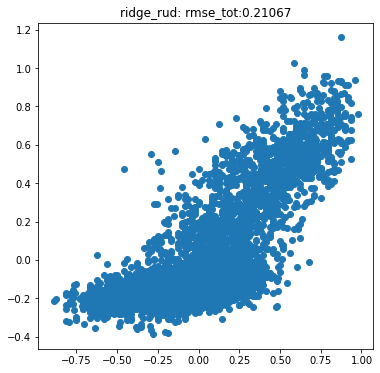

ridge_rud VAL: 0.70051


MODEL lgb_rud
fold:0 rmse_train:0.16007, rmse_valid:0.18066
fold:1 rmse_train:0.16271, rmse_valid:0.17075
fold:2 rmse_train:0.16040, rmse_valid:0.17931
fold:3 rmse_train:0.16203, rmse_valid:0.17037
fold:4 rmse_train:0.16070, rmse_valid:0.18180
tot rmse_tot:0.17665


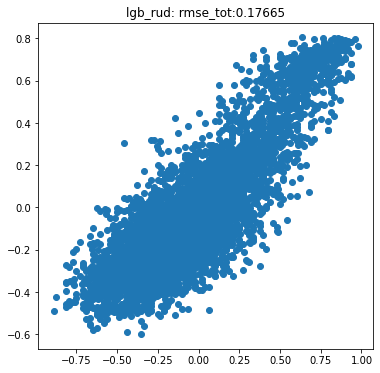

lgb_rud VAL: 0.70636


MODEL rf_rud
fold:0 rmse_train:0.15255, rmse_valid:0.18897
fold:1 rmse_train:0.15535, rmse_valid:0.17605
fold:2 rmse_train:0.15354, rmse_valid:0.18681
fold:3 rmse_train:0.15528, rmse_valid:0.17722
fold:4 rmse_train:0.15371, rmse_valid:0.18628
tot rmse_tot:0.18315


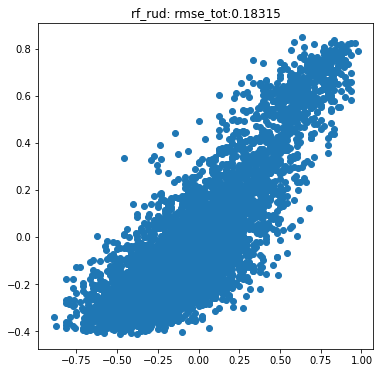

rf_rud VAL: 0.70742


MODEL xgb_rud
fold:0 rmse_train:0.14775, rmse_valid:0.18015
fold:1 rmse_train:0.15008, rmse_valid:0.16934
fold:2 rmse_train:0.14853, rmse_valid:0.17943
fold:3 rmse_train:0.14962, rmse_valid:0.17097
fold:4 rmse_train:0.15217, rmse_valid:0.18009
tot rmse_tot:0.17606


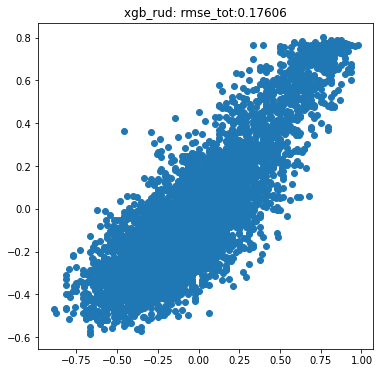

xgb_rud VAL: 0.70231




In [4]:
cols = ['original_toxicity', 'original_severe_toxicity', 'original_obscene',
       'original_threat', 'original_insult', 'original_identity_attack',
       'unbiased_toxicity', 'unbiased_severe_toxicity', 'unbiased_obscene',
       'unbiased_identity_attack', 'unbiased_insult', 'unbiased_threat',
       'unbiased_sexual_explicit', 'multilingual_toxicity',
       'multilingual_severe_toxicity', 'multilingual_obscene',
       'multilingual_identity_attack', 'multilingual_insult',
       'multilingual_threat', 'multilingual_sexual_explicit',
       'original-small_toxicity', 'original-small_severe_toxicity',
       'original-small_obscene', 'original-small_threat',
       'original-small_insult', 'original-small_identity_attack',
       'unbiased-small_toxicity', 'unbiased-small_severe_toxicity',
       'unbiased-small_obscene', 'unbiased-small_identity_attack',
       'unbiased-small_insult', 'unbiased-small_threat',
       'unbiased-small_sexual_explicit', 
        "jc_tfidf_toxic","jc_tfidf_severe_toxic","jc_tfidf_obscene","jc_tfidf_threat","jc_tfidf_insult","jc_tfidf_identity_hate"]

def lgb_model ():
    return lgb.LGBMRegressor(random_state=2022, 
                                 learning_rate=0.1,  
                                 subsample=0.8, colsample_bytree=0.8,  
                                 num_leaves=6,
                                )
def xgb_model ():
    return xgb.XGBRegressor(random_state=2022, learning_rate=0.1,  
                             subsample=0.6, colsample_bytree=0.6,  max_depth=4,
                             reg_alpha=1.0,
                            )
 
def rf_model():
    return RandomForestRegressor(random_state=2022, max_features=3, max_depth=8)

def ridge_model():
    return Ridge(alpha=1.0)


rud_pair, rud_text = create_rud_features ()
val_pair, val_text = create_validation_features ()

y_true = rud_text["offensiveness_score"]



model_name = "ridge_rud"
print(f"MODEL {model_name}")
pred_ridge = cv_sklearn ( model_name = model_name, fun_create_model = ridge_model,  df = rud_text , cols = cols , 
                       score_column = "offensiveness_score")
show_rmse (y_true, pred_ridge, model_name)
pred_val_ridge = sklearn_predict (val_text, model_path = "../models/", model_name =model_name, cols=cols)
val_score = validate (val_pair,val_text, pred_val_ridge)
print(f"{model_name} VAL: {val_score:.5f}")
print()
print()


model_name = "lgb_rud"
print(f"MODEL {model_name}")
pred_lgb = cv_sklearn ( model_name = model_name, fun_create_model = lgb_model,  df = rud_text , cols = cols , 
                       score_column = "offensiveness_score",
                       early_stopping_rounds = 50)
show_rmse (y_true, pred_lgb, model_name)
pred_val_lgb = sklearn_predict (val_text, model_path = "../models/", model_name =model_name, cols=cols)
val_score = validate (val_pair,val_text, pred_val_lgb)
print(f"{model_name} VAL: {val_score:.5f}")
print()
print()


model_name = "rf_rud"
print(f"MODEL {model_name}")
pred_rf = cv_sklearn ( model_name = model_name, fun_create_model = rf_model, df = rud_text , cols = cols , score_column = "offensiveness_score")
show_rmse (y_true, pred_rf, model_name)
pred_val_rf = sklearn_predict (val_text, model_path = "../models/", model_name =model_name, cols=cols)
val_score = validate (val_pair,val_text, pred_val_rf)
print(f"{model_name} VAL: {val_score:.5f}")
print()
print()



model_name = "xgb_rud"
print(f"MODEL {model_name}")

pred_xgb = cv_sklearn ( model_name = model_name, fun_create_model = xgb_model,  
                       df = rud_text , cols = cols , 
                       score_column = "offensiveness_score",
                       early_stopping_rounds = 50)
show_rmse (y_true, pred_xgb, model_name)
pred_val_xgb = sklearn_predict (val_text, model_path = "../models/", model_name =model_name, cols=cols)
val_score = validate (val_pair,val_text, pred_val_xgb)
print(f"{model_name} VAL: {val_score:.5f}")
print()
print()

In [5]:
pred_val_ensemble = pred_val_ridge + pred_val_lgb + pred_val_rf + pred_val_xgb
val_score = validate (val_pair,val_text, pred_val_ensemble)
print(f"Ensemble VAL: {val_score:.5f}")

Ensemble VAL: 0.70749
